# Practice 1
**Autor: Jorge Vázquez Pérez**

## Table of Contents

1. [Develop a quantum algorithm based on gates and circuits](#apartado1)
    + [QPE explanation](#apartado1a)
    + [QPE distributed](#apartado1b)
2. [Characterize the circuit](#apartado2)
3. [Run the circuit](#apartado3)
4. [Export/import the circuit](#apartado4)

In this practice the distributed version of the Quantum Phase Estimation (QPE) algorithm is going to be carried out along with an explanation of its difficulties and details. First of all, before any circuit and algorithm implementation all the necessary imports will be carried out.

In [1]:
import math
import numpy as np

from bitstring import BitArray

# Importing Qiskit
from qiskit import IBMQ, Aer, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Gate

from qiskit.circuit.library import QFT
from qiskit.circuit.library import PhaseGate

## 1. Develop a quantum algorithm based on gates and circuits <a class="anchor" id="apartado1"></a>

First, we are going to develop the normal Quantum Phase Estimation circuit in order to understand the intricacies of this algorithm and, after all the concepts are clear, we are going to explain the distributed version. This version is really similar with the addition of two subcircuits called Cat Entangler and Car Disentangler, which are used in the teleportation protocol in numerous applications in quantum computing, among which distributed quantum computing is found. It is important to mention that the mathemathical explanations of the circuit will be left aside and can be found in the [Qiskit Textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation).

### QPE explanation <a class="anchor" id="apartado1a"></a>
But first, let's explain what the QPE algorithm is all about. This algorithm, as its own name says, tries to estimates a phase. More specifically, 

> Giving a state $|\psi\rangle$ and a gate $U$ such that $U|\psi\rangle = e^{2\pi i\theta}|\psi\rangle$, QPE tries to estimate the value of $\theta$.

Basically, what the QPE algorithm does is estimate the phase that a specific gate applies to a specific eigenvector. Once we know this, lets construct the circuit and explain what is the purpose of each part. First, we define the quantum and classical registers used by the circuit.

In [2]:
# Definition of the registers and the circuit (n_eval + 1 qubits)
n_eval = 4

qr_eval = QuantumRegister(n_eval, "eval")
qr_state = QuantumRegister(1, "\psi")
cl_eval = ClassicalRegister(n_eval, "cl_eval")

qr_list = [qr_eval, qr_state]
qpe = QuantumCircuit(*qr_list, cl_eval, name="QPE")

In the previous piece of code we defined the `n_eval` variable, which represents the number of qubits that are going to be evaluated and that, moreover, represent the amount of precision that we aim in guessing the phase. So if the phase is $0.25$, then with `n_eval = 4` the result will be $0.2500$, but if the phase was to be $0.3456734$, then with `n_eval = 4` would lost information of the 
phase. A compromise between computational cost of adding qubits and precision in the phase guessing is always present.

Now the evaluation qubits are put in superposition and the $|\psi\rangle$ qubit is initialized as the eigenvector of the $U$ gate that is going to be used. In this case, we have $|\psi\rangle = |1\rangle$ because $U = P(\phi)$ (the phase gate), as we will next.

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


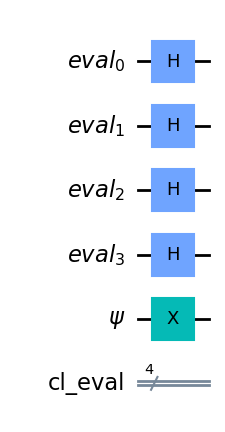

In [3]:
# Declaration of the gates
qpe.x(qr_state[0])
qpe.h(qr_eval)
qpe.draw("mpl")

As previously mentioned, the gate employed is the phase gate $P(\phi)$ which has the matrix form:

\begin{pmatrix}
1 & 0 \\
0 & e^{i\phi}
\end{pmatrix}.

It is now obvious, not only why we use this gate, but also why $|\psi\rangle = |1\rangle$, takin into acount that $P(\phi) |1\rangle = e^{i\phi}|1\rangle$. This property of the phase gate will allow us to take $\phi = 2\pi\theta$, and, therefore, to be able to test the algorithm easily (because $\theta$ is precisely the value returned by the QPE). It is needed to remark that this gate is an inmediate choice in terms of exemplification, but $U$ can be any gate as long as we initialize $\psi$ to a pertinent eigenvalue or another state that will give a interest outcome (as it is the case for the value $|1\rangle$ and the modular multiplication gate used in Shor's algorithm, which employs precisely the QPE scheme). 

Returning to our current case, we see that the chosen gate is applied $2^{i}$ times to the $\psi$ qubit controlled by the $n\_eval_i$ qubit.

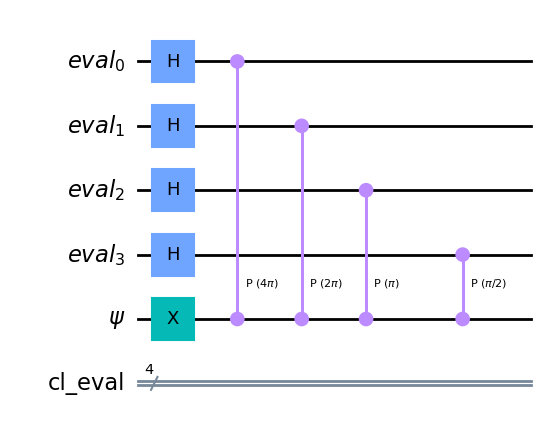

In [4]:
phase_input = 0.25

for j in range(n_eval):
        qpe.append(PhaseGate(theta = 2*math.pi*phase_input).power(2**(n_eval-j-1)).control(), qargs=[j] + qr_state[:])
qpe.draw("mpl")

And last, but not least, the inverse of the Quantum Fourier Transform is applied at the end of the circuit only to the evaluation qubits. After this, precisely the evaluation qubits are measured and the result of the quantum circuit is obtained. As we will see, the result obtained is not exactly the phase aimed, but a binary number $b$ which represented as decimal and divided by $2^{n\_eval}$ returns precisely $\theta$:

$$\theta = \frac{b}{2^{n\_eval}}$$

This will be tested in the [Run the circuit](#apartado3) section.

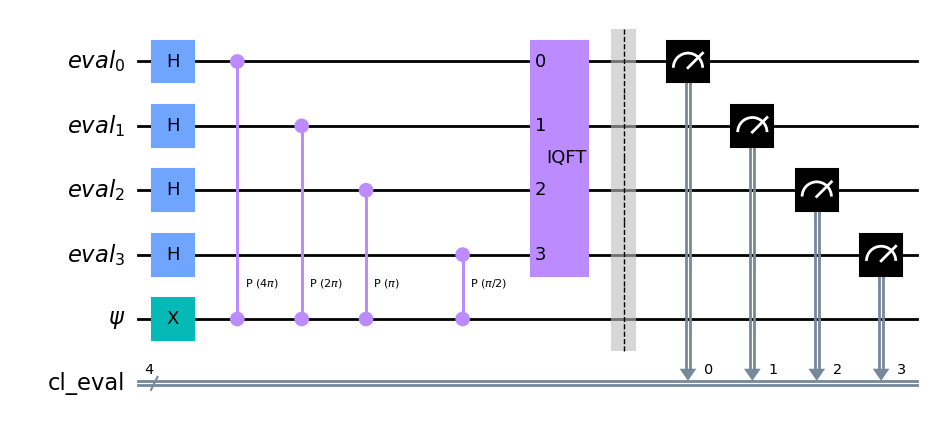

In [5]:
# Add the inverse QFT in both cases and measure the eval qubits  
iqft = QFT(n_eval, inverse=True, do_swaps=False)  
qpe.append(iqft, qargs=qr_eval)
qpe.barrier()
for n in range(n_eval):
    qpe.measure(qr_eval[n],cl_eval[n])

qpe.draw("mpl")

Below the whole construction is performed into a method that returns the circuit to be able to use it along the notebook when needed.

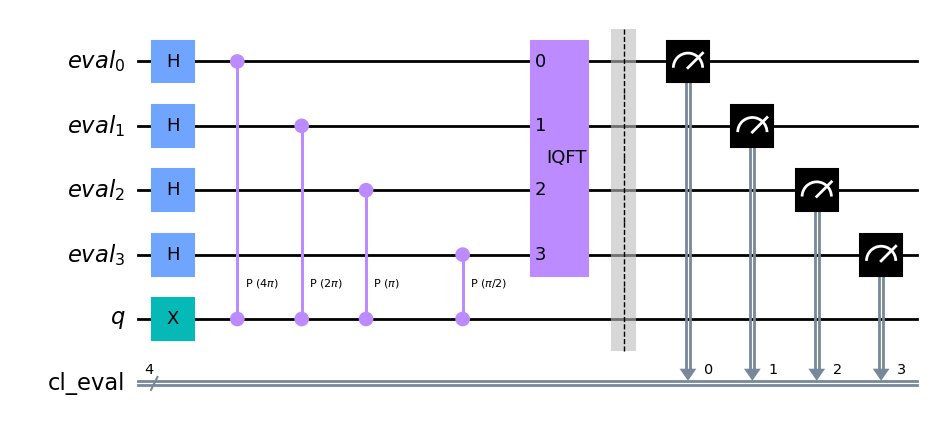

In [6]:
def qpe(gate: Gate = PhaseGate, psi: np.ndarray=[0,1], n_eval: int=4, param: float=0, measurements: bool = True):
    """Usual implementation of QPE algorithm."""

    # Definition of the registers and the circuit (n + 1 qubits)
    qr_eval = QuantumRegister(n_eval, "eval")
    qr_state = QuantumRegister(1, "q")
    cl_eval = ClassicalRegister(n_eval, "cl_eval")
    
    qr_list = [qr_eval, qr_state]
    qpe = QuantumCircuit(*qr_list, cl_eval, name="QPE")
    
    # Declaration of the gates
    qpe.x(qr_state[0])
    qpe.h(qr_eval)
    for j in range(n_eval):
        qpe.append(gate(param).power(2**(n_eval-j-1)).control(), qargs=[j] + qr_state[:])
    
    # Add the inverse QFT in both cases and measure the eval qubits  
    iqft = QFT(n_eval, inverse=True, do_swaps=False)  
    qpe.append(iqft, qargs=qr_eval)
    qpe.barrier()
    if measurements:
        for n in range(n_eval):
            qpe.measure(qr_eval[n],cl_eval[n])
    return qpe

phase_input = 0.25
qpe_monol = qpe(param = 2*math.pi*phase_input)
qpe_monol.draw("mpl")

### Distributed version <a class="anchor" id="apartado1b"></a>

After the classic QPE version was explained, we move into the distributed version. In this version everything is exactly the same with the exception of the control nature of the $U$ gate. In the monolithic case a simple control among the gate and the $i^{th}$ evaluation qubit is performed, but in the distributed version we need to perform a Cat Entangler before the control operation and a Cat Disentangler after. Let's see how this two gates are contructed and lets explain the effect.

1. **Cat Entangler**. This circuit performs an operation that if a the qubit $q_0$ is in the state $|q_0\rangle = \alpha|0\rangle + \beta|1\rangle$, then, after the cat entangler the qubits $q_0$, $q_1$ and $q_2$ will be in the state $|q_2q_1q_0\rangle = \alpha|000\rangle + \beta|101\rangle$, being $q_0$, $q_1$ and $q_2$ the same ones as represented in the circuit below. The utility of this is that, now, operating in the qubit $q_2$ is quivalent to operate in the qubit $q_0$. This is really useful in distributed quantum computing, because if $q_0$ and $q_2$ were in different quantum computers we could operate in the quantum computer of $q_2$ using the information contained in $q_0$. This could be done if we could generate two entangle pairs (in our case $q_1$ and $q_2$) and send them to different computers (the $q_1$ to the computer containing $q_0$ and $q_2$ to another one). The generation of this entangle state is simulated in Qiskit using the bell circuit thta can be seen before the barrier.

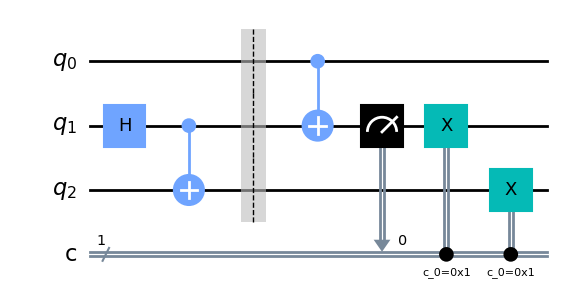

In [7]:
def cat_entangler(num_qubits: int = 3):
    cat_ent = QuantumCircuit(3, 1)
    
    # Create the cat state
    cat_ent.h(1)
    for i_qubit in range(1,num_qubits-1):
        cat_ent.cx(i_qubit, i_qubit+1)
    
    # Execute the teleportation
    cat_ent.barrier()

    cat_ent.cx(0, 1)
    cat_ent.measure(1, 0)
    for i_qubit in range(1,num_qubits):
        cat_ent.x(i_qubit).c_if(0, 1)
    
    return cat_ent

cat_ent = cat_entangler()
cat_ent.draw("mpl")

2. **Cat Disentangler**. This circuit is, precisele the inverse of the Cat Entangler. It is applied after all the operations are done to set all the entangle pairs again to the state $|0\rangle$ and leaves $q_0$ with the state that should have as if the operations were performed without the Cat Entangler.

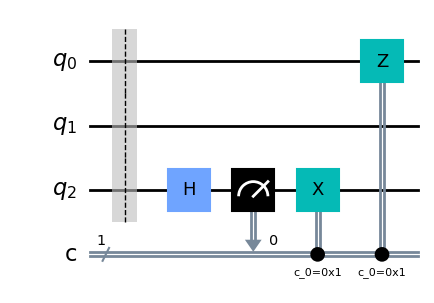

In [8]:
def cat_disentangler(num_qubits: int = 3):
    cat_ent = QuantumCircuit(3, 1)
    
    # Create the cat state
    cat_ent.barrier()
    for i_qubit in range(2,num_qubits):
        cat_ent.h(i_qubit)

    for i_qubit, j_clbit in zip(range(2, num_qubits), range(num_qubits-2)):
        cat_ent.measure(i_qubit, j_clbit)
        cat_ent.x(i_qubit).c_if(j_clbit, 1)
        cat_ent.z(0).c_if(j_clbit, 1)
    
    return cat_ent

cat_dis = cat_disentangler()
cat_dis.draw("mpl")


And just as we did before with the monolithic version, we will incorporate the whole construction into a function for reusability purposes. We did not enter into the analythic explanation of this circuits because it exceeds the scope of the practice.

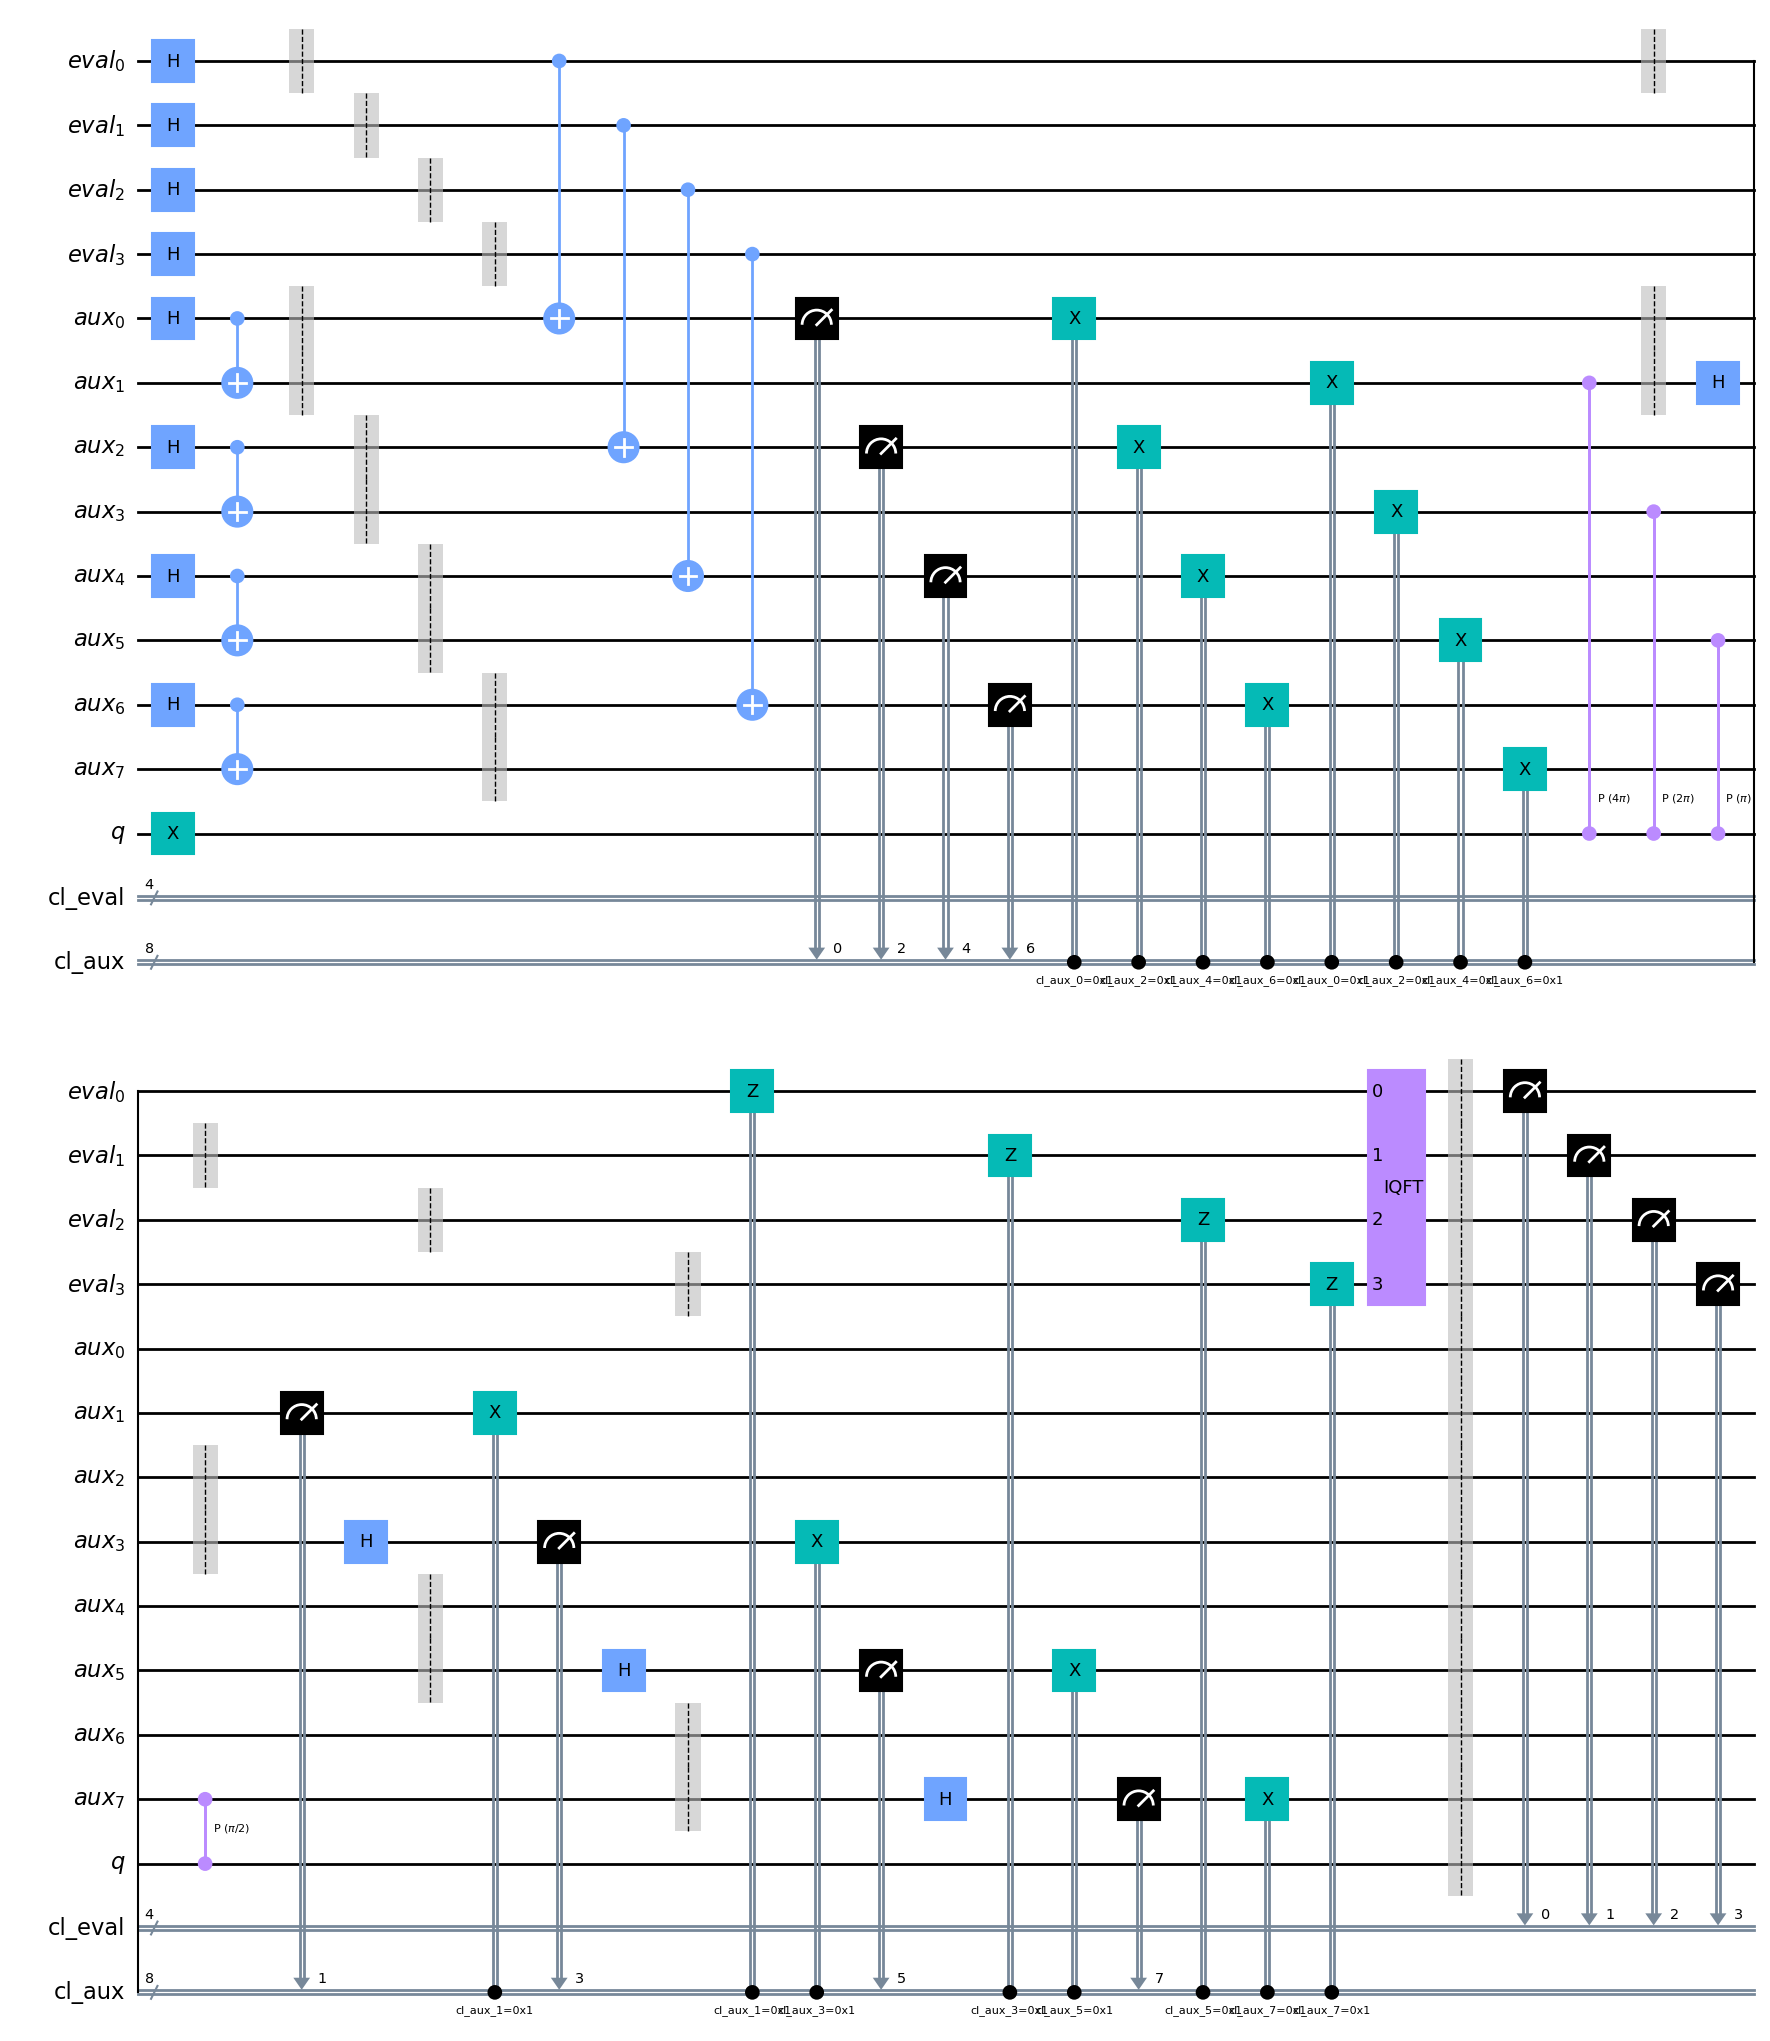

In [9]:
def qpe_distributed(gate: Gate = PhaseGate, psi: np.ndarray=[0,1], n_eval: int=4, param: float=0, measurements: bool = True):
    """Distributed implementation using cat entangler and cat disantangler."""

    # Definition of the registers and the circuit (3n + 1 qubits)
    qr_eval = QuantumRegister(n_eval, "eval")
    qr_aux = QuantumRegister(2*n_eval, "aux")
    qr_state = QuantumRegister(1, "q")
    cl_eval = ClassicalRegister(n_eval, "cl_eval")
    cl_aux = ClassicalRegister(2*n_eval, "cl_aux")

    qr_list = [qr_eval, qr_aux, qr_state]
    cl_list = [cl_eval, cl_aux]
    qpe = QuantumCircuit(*qr_list, *cl_list, name="QPE")

    # Declaration of the gates
    qpe.x(qr_state[0])
    qpe.h(qr_eval)

    cat_ent = cat_entangler()
    cat_dis = cat_disentangler()

    for j in range(n_eval):
        qubits_list = [qr_eval[j], qr_aux[2*j], qr_aux[2*j + 1]]
        qpe.compose(cat_ent, qubits=qubits_list, clbits=[cl_aux[2*j]], inplace=True)
        qpe.append(PhaseGate(theta = param).power(2**(n_eval-j-1)).control(), qargs=[qr_aux[2*j + 1]] + qr_state[:])
        qpe.compose(cat_dis, qubits=qubits_list, clbits=[cl_aux[2*j+1]], inplace=True)

    # Add the inverse QFT in both cases and measure the eval qubits  
    iqft = QFT(n_eval, inverse=True, do_swaps=False)  
    qpe.append(iqft, qargs=qr_eval)
    qpe.barrier()
    if measurements:
        for n in range(n_eval):
            qpe.measure(qr_eval[n],cl_eval[n])

    return qpe

n_eval = 4
phase_input = 0.25
qpe_distr = qpe_distributed(PhaseGate, n_eval=4, param=2*math.pi*phase_input)

qpe_distr.draw("mpl")

## Characterize the circuit <a class="anchor" id="apartado2"></a>

In this brief chapter we are going to analize the width, the size and the depth of the circuit.

1. Width. The width is calculated add ing the total amount of qubits employed and the classical bits.
2. Size. The size is the number of gates employed in the circuit.
3. Depth. The depth is the number of layers in the circuit, meaning, the number of gates in the longest path from begining to end taking int account every qubit.

In [10]:
print("The width of the circuit is: {}".format(qpe_distr.width()))
print("The size of the circuit is: {}".format(qpe_distr.size()))
print("The depth of the circuit is: {}".format(qpe_distr.depth()))

The width of the circuit is: 25
The size of the circuit is: 54
The depth of the circuit is: 16


It is interesting to compare this values with the values of the monolothic version and realize that all this metrics are way bigger in the distributed version.

In [11]:
print("The width of the circuit is: {}".format(qpe_monol.width()))
print("The size of the circuit is: {}".format(qpe_monol.size()))
print("The depth of the circuit is: {}".format(qpe_monol.depth()))

The width of the circuit is: 9
The size of the circuit is: 14
The depth of the circuit is: 7


Moreover, if we now decompose into $U$ gates we see an impressive increase in the amount of gates. It is important to notice that the `reps=9` argument in the `decompose()` method represents the amount of times the method has to be applied in order to have only $U$ gates. 

(at the of the notebook we called $U$ to a generic unitary, but in this context is the generic representation of a unitary gate employed by Qiskit)

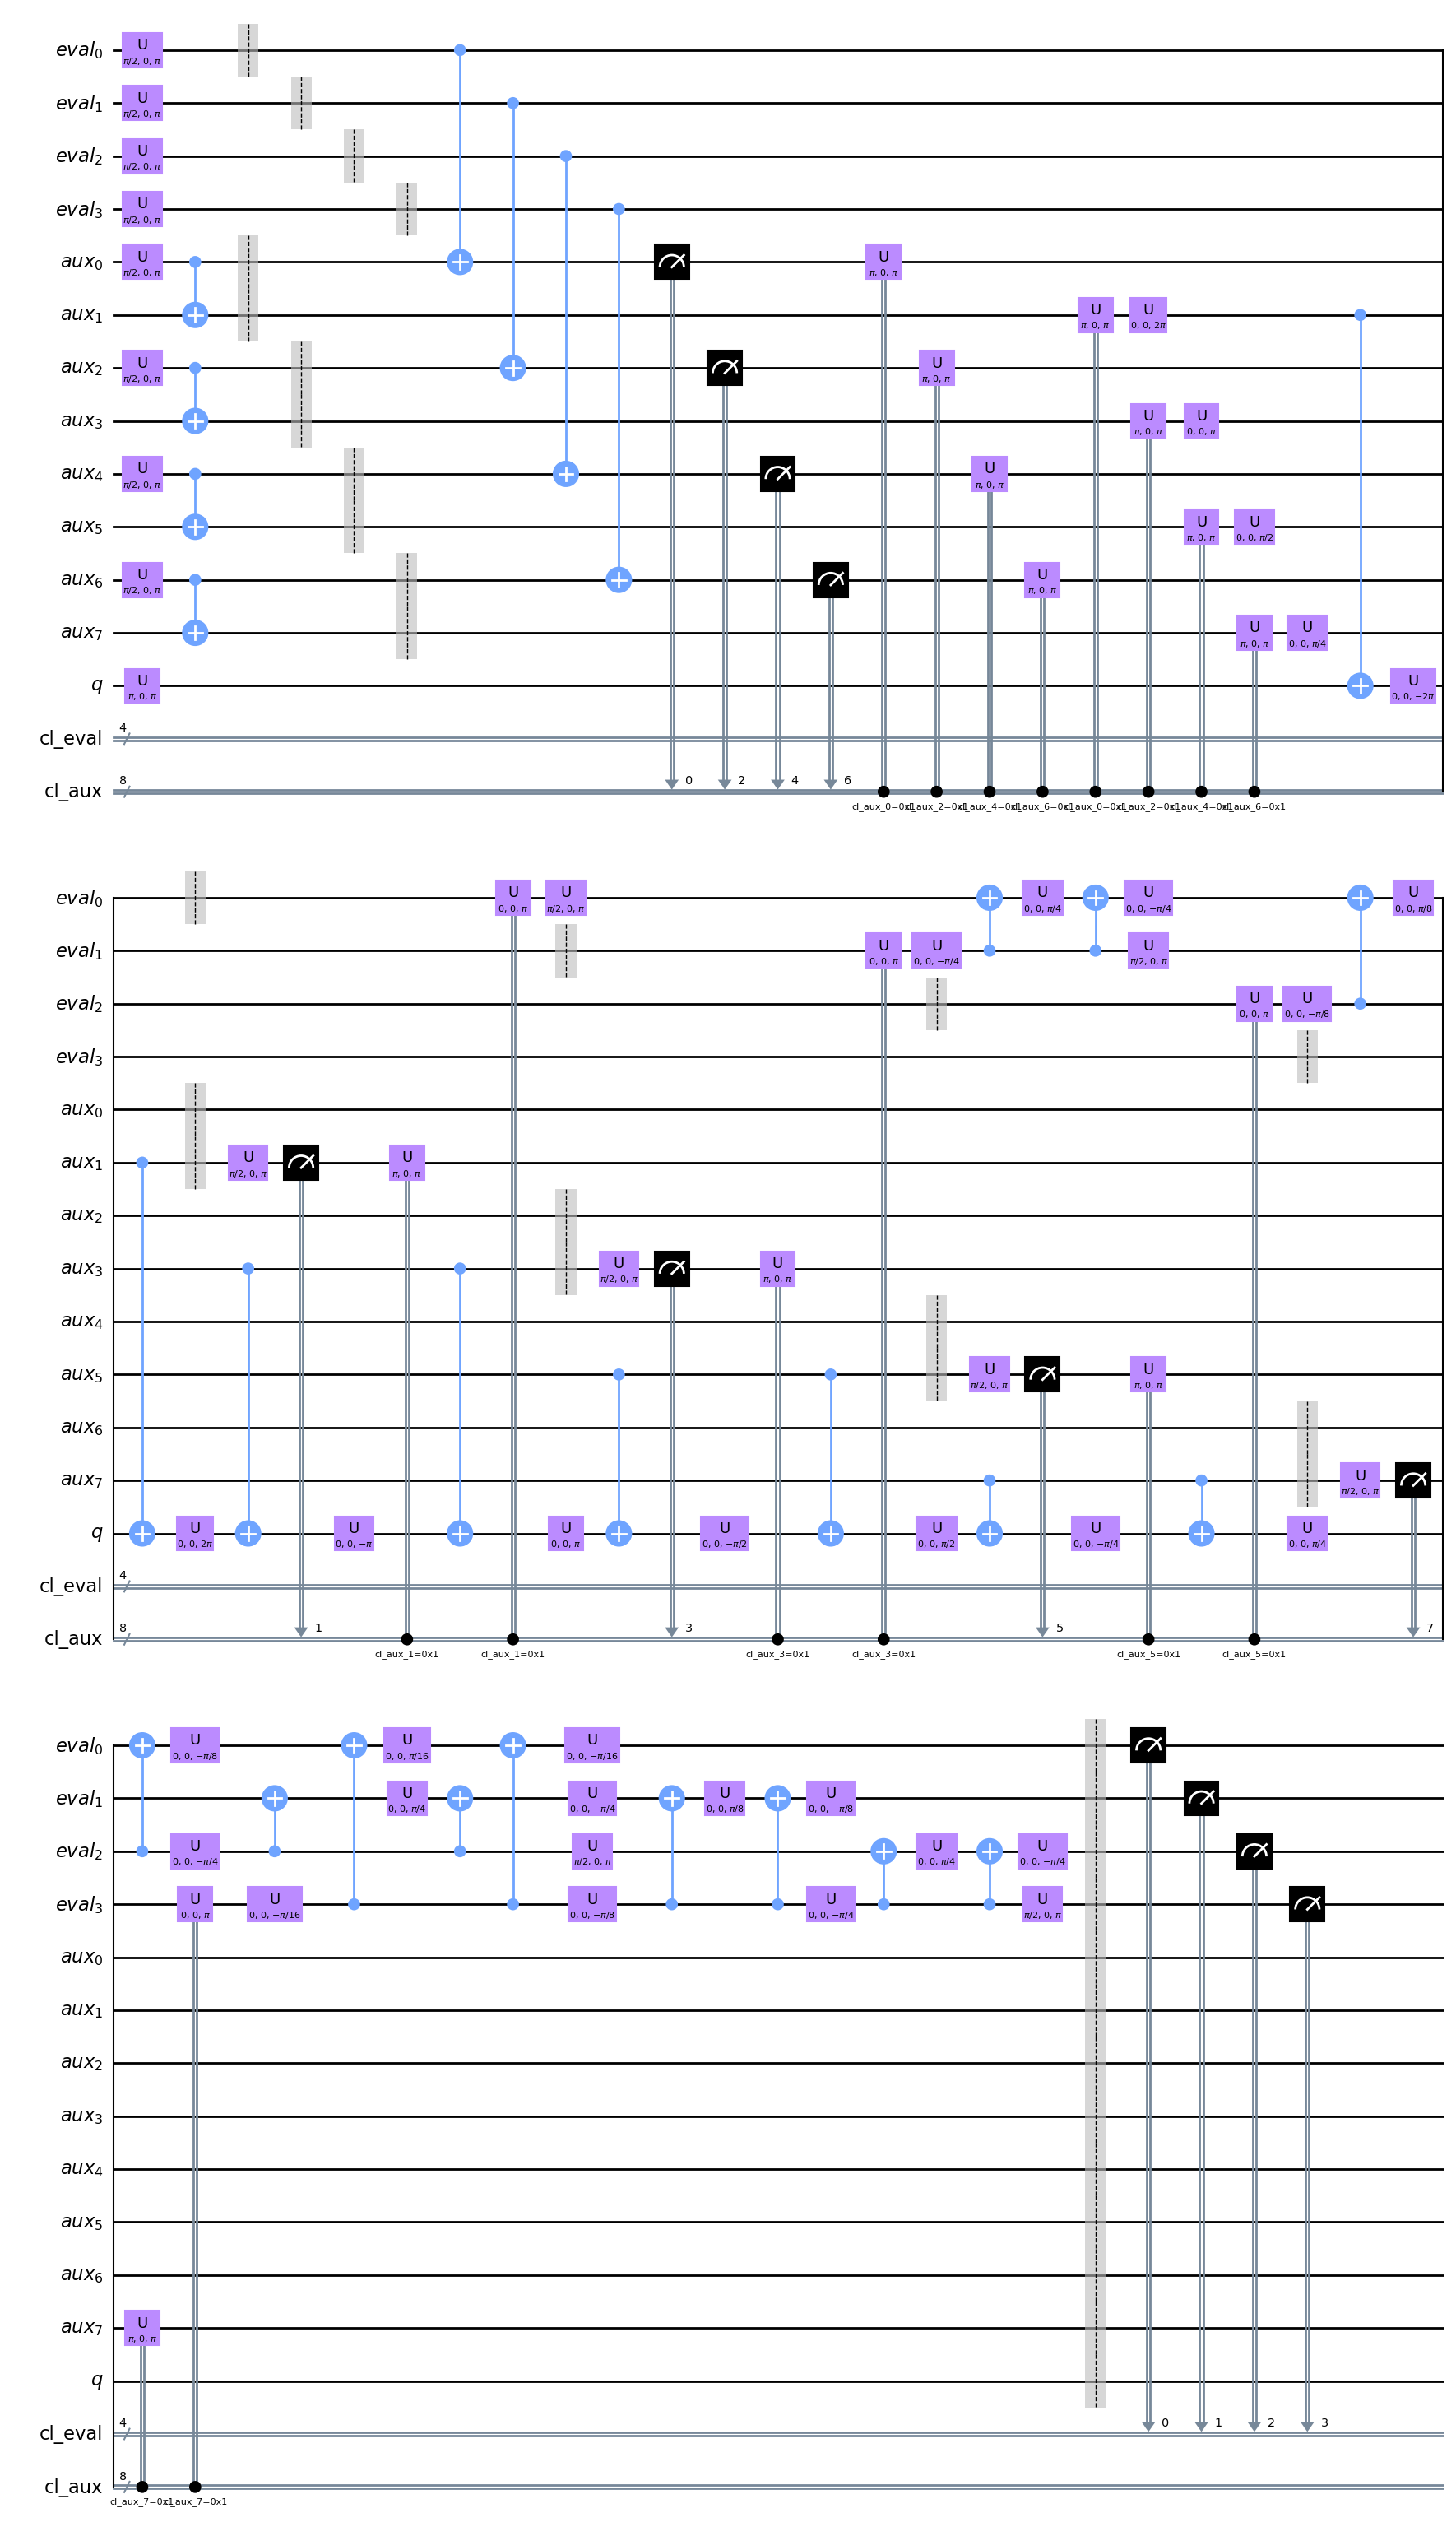

In [12]:
qpe_distr_decomposed = qpe_distr.decompose(reps=9)
qpe_distr_decomposed.draw("mpl")

And, as we expected, the previous metrics highly increase, with exception of the width that remains unalterered (because we didn't add any qubit). 

In [13]:
print("The width of the circuit is: {}".format(qpe_distr_decomposed.width()))
print("The size of the circuit is: {}".format(qpe_distr_decomposed.size()))
print("The depth of the circuit is: {}".format(qpe_distr_decomposed.depth()))

The width of the circuit is: 25
The size of the circuit is: 103
The depth of the circuit is: 40


## Run the circuit <a class="anchor" id="apartado3"></a>

Now it's time to run the circuits we constructed and see the results. First we are going to define some useful functions to postprocess the data obtained in the circuit.

1. `_process_answer`: in the distributed version a lot of intermediate measures are performed and they mess the result that we are interested in, which is the value of the evaluation qubits. This fucntion eliminates those intermediate measure values and retrieves only the valuable ones.
2. `execute_measurements`: a function to make the measurements more reusable and readable.
3. `get_phase`: gets the dictonary containing the results of the evaluation qubits and performs the classical postprocessing corresponding to get the value of $\theta$ as previously explained:
$$\theta = \frac{b}{2^{n\_eval}}$$

In [14]:
from qiskit.result.result import Result

def _process_answer(counts: dict) -> dict:
    """Auxiliar funtion to process the counts and erase the intermediate measures from the result.
    Args:
        counts: Result from the measurements of the quantum circuit.
    Returns:
        dict: Dictionary with the significant measures.
    """
    new_dict = {}
    for key, count in counts.items():
        keys = key.split()
        if len(keys) < 2:
            return
        new_key = keys[1]
        if new_key in new_dict:
            new_dict[new_key] = new_dict[new_key] + count
        else:
            new_dict[new_key] = count
    return new_dict

def execute_measurements(circuit: QuantumCircuit, simulator: str = "aer_simulator") -> Result:
    """Function to perform a measurement in an indicated backend simulator.
    Args:
        circuit: Quantum circuit to measure.
        simulator: Name of the simulator
    Returns:
        Result: A Result Qiskit object with the results of the measurements.
    """
    sim = Aer.get_backend(simulator)
    results = sim.run(transpile(circuit, sim)).result()

    return results

def get_phase(counts: dict, n_eval: int = 4, filter_counts: bool = False, return_counts: bool = False) -> float:
    """Function calculate the phase.
    Args:
        counts: Counts of the measurement results.
        n_eval: Number of evaluation qubits (precision).
        filter_counts: Bool value to determine whether to apply _process_answer.
        return_counts: Bool to determine if the counts are returned or only the phase value.
    Returns:
        float: Guess of the phase.
    """
    
    if filter_counts:
        counts = _process_answer(counts=counts)

    evaluation = BitArray(bin = max(counts, key=counts.get)).int
    phase = evaluation/math.pow(2, n_eval)

    if return_counts:
        return counts, phase
    return phase

Let's now see if the circuit behaves as expected executing it and processing the results.

In [15]:
theta = 0.25
qpe_distr = qpe_distributed(PhaseGate, param=2*math.pi*theta)

# Simulation of the circuit
results = execute_measurements(qpe_distr, "qasm_simulator")
counts = results.get_counts()

# Post process of the results
filtered_counts, phase = get_phase(counts, filter_counts=True, return_counts=True)

print("\n··· Counts obtained ···")
print("The counts of the measurements are:")
print(filtered_counts)

print("\n··· Results after postprocessing ···")
print("The value of the phase is: {phase:.{n_eval}f}".format(phase=phase, n_eval=4))


··· Counts obtained ···
The counts of the measurements are:
{'0100': 1024}

··· Results after postprocessing ···
The value of the phase is: 0.2500


In the previous case we see that the phase is calcultated with perfect precision and certainty, noticing that the result of the measument is always the same value $b = 0100$. Let's use another phase value and look at what happens.

In [16]:
theta = 0.333
qpe_distr = qpe_distributed(PhaseGate, param=2*math.pi*theta)

# Simulation of the circuit
results = execute_measurements(qpe_distr, "qasm_simulator")
counts = results.get_counts()

# Post process of the results
filtered_counts, phase = get_phase(counts, filter_counts=True, return_counts=True)

print("\n··· Counts obtained ···")
print("The counts of the measurements are:")
print(filtered_counts)


print("\n··· Results after postprocessing ···")
print("The value of the phase is: {phase:.{n_eval}f}".format(phase=phase, n_eval=4))


··· Counts obtained ···
The counts of the measurements are:
{'0011': 12, '0101': 741, '1001': 7, '1110': 8, '1000': 14, '0110': 153, '0100': 35, '0111': 29, '0010': 6, '0001': 4, '1111': 2, '1010': 3, '0000': 4, '1100': 1, '1011': 3, '1101': 2}

··· Results after postprocessing ···
The value of the phase is: 0.3125


In this case, the precision is not perfect and the measurement is not deterministic. In fact, we can see that the value $b = 0101$ is the one which accumulates the majority of the probability but not all of it. This is because $100\%$ certainty and precision is only obtained when $\theta = \frac{1}{2^n}$ and when the number of evaluation qubits is enough to represent the $2^n$ value, as it is obvious. In any other case, the value obtained will be aproximate and, the more evaluation qubits employed, the more close the result will get to the actual value.

Now, for the statevector simulation, we will resume to the monolithic version due to the imposibility of this simulator to cope with intermediate measures. In any case, this is not a problem because we have seen that the distributed version works properly and with the statevector of monolithic we will see the state that the measurements on the distributed version reflected. It is important to notice that in the statevector simulation the qpe is contructed without the measurements to avoid the collapse and that the las qubit (which is $|\phi\rangle$) maintains always the $|1\rangle$ value.

In [17]:
phase_input = 0.25
qpe_circuit = qpe(param = 2*math.pi*phase_input, measurements=False)

# Simulation of the circuit
results = execute_measurements(qpe_circuit, "statevector_simulator")
psi = results.get_statevector(qpe_circuit)

psi.draw("latex")

<IPython.core.display.Latex object>

And with $\theta = 0.333 \neq \frac{1}{2^n}, \; \forall n \in \mathbb{N}$.

In [18]:
phase_input = 0.333
qpe_circuit = qpe(param = 2*math.pi*phase_input, measurements=False)

# Simulation of the circuit
results = execute_measurements(qpe_circuit, "statevector_simulator")
psi = results.get_statevector(qpe_circuit)

psi.draw("latex")

<IPython.core.display.Latex object>

And, to end this section, we will visualize the results employing the qsphere available on Qiskit, which will show how the probability is accumulated in the $|10101\rangle$ as we can observe in the previous statevector and in the measuments obtained using the qasm_simulator.

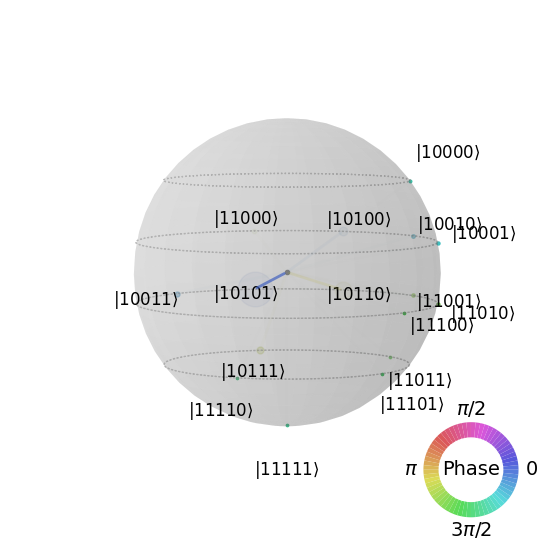

In [19]:
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_city, plot_state_qsphere

phase_input = 0.333
qpe_circuit = qpe(param = 2*math.pi*phase_input, measurements=False)

# Simulation of the circuit
results = execute_measurements(qpe_circuit, "statevector_simulator")
psi = results.get_statevector(qpe_circuit)

plot_state_qsphere(psi)

## Export/import the circuit <a class="anchor" id="apartado4"></a>

In this final part, the interoperability of Qiskit with OpenQASM is going to be exposed and explained. First of all, as it happened before with the statevector simulator, the `qasm()` method doesn't support intermediate measures, as it can be seen below.

In [20]:
theta = 0.25
qpe_distr = qpe_distributed(PhaseGate, param=2*math.pi*theta)
qasm_str = qpe_distr.qasm()

print(qasm_str)

QASM2ExportError: "OpenQASM 2 can only condition on registers, but got '{operation.condition[0]}'"

And because of this, the circuit that we are going to employ in this section is the monolithic version which, as it is demonstrated below, can be easily translated to OpenQASM.

In [21]:
phase_input = 0.25
qpe_circuit = qpe(param = 2*math.pi*phase_input)
qasm_str = qpe_circuit.qasm()

print(qasm_str)

OPENQASM 2.0;
include "qelib1.inc";
gate gate_IQFT_dg q0,q1,q2,q3 { h q0; cp(-pi/2) q1,q0; h q1; cp(-pi/4) q2,q0; cp(-pi/2) q2,q1; h q2; cp(-pi/8) q3,q0; cp(-pi/4) q3,q1; cp(-pi/2) q3,q2; h q3; }
gate gate_IQFT q0,q1,q2,q3 { gate_IQFT_dg q0,q1,q2,q3; }
qreg eval[4];
qreg q[1];
creg cl_eval[4];
x q[0];
h eval[0];
h eval[1];
h eval[2];
h eval[3];
cp(4*pi) eval[0],q[0];
cp(2*pi) eval[1],q[0];
cp(pi) eval[2],q[0];
cp(pi/2) eval[3],q[0];
gate_IQFT eval[0],eval[1],eval[2],eval[3];
barrier eval[0],eval[1],eval[2],eval[3],q[0];
measure eval[0] -> cl_eval[0];
measure eval[1] -> cl_eval[1];
measure eval[2] -> cl_eval[2];
measure eval[3] -> cl_eval[3];



Now, to do the reverse translation (from a OpenQASM string to a qiskit circuit), we need to define the phase gate as a custom instruction using the `CustomIntruction` object. This is due to the lack of this operation in the translation protocol established by Qiskit. We can see that the circuit after the transalation is the same as before.

/home/jvazquez/miniconda3/envs/basic-quantum/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


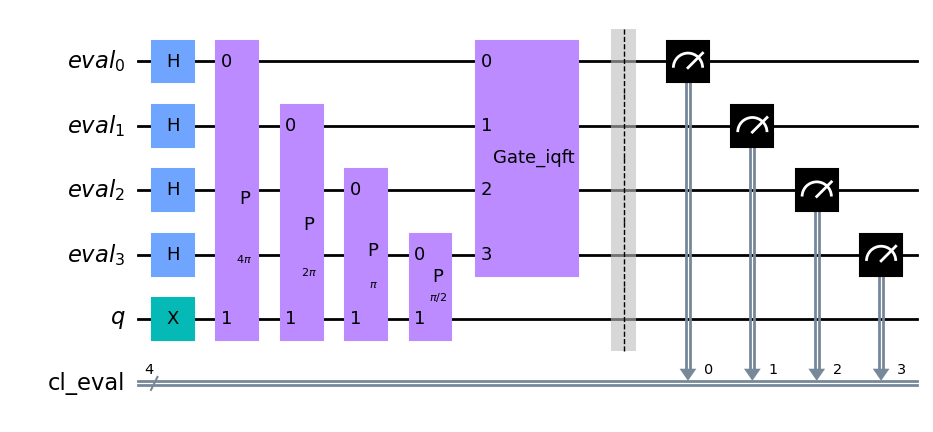

In [22]:
from qiskit.qasm2 import loads, CustomInstruction
customs = [
    CustomInstruction(name="cp", num_params=1, num_qubits=2, constructor=PhaseGate, builtin=True),
]

qpe_circuit_qasm = loads(qasm_str, custom_instructions=customs)
qpe_circuit_qasm.draw("mpl")

And, to check that the circuit is precisely the same circuit we can execute it as we did in the previous section and see that the results are precisely the same.

In [23]:
# Simulation of the circuit
results = execute_measurements(qpe_circuit_qasm, "qasm_simulator")
counts = results.get_counts()

# Post process of the results
phase = get_phase(counts)

print("\n··· Results after postprocessing ···")
print("The value of the phase is: {phase:.{n_eval}f}".format(phase=phase, n_eval=4))


··· Results after postprocessing ···
The value of the phase is: 0.2500
